<h1>Social Network Analysis</h1>


The goal of this byte is to explore some algorithms and visualizations relating to networks

K-Core Algorithm Introduction:
============
* K-Core is an approach of simplifying a graph by removing the edges that have small degrees. The goal of the algorithm is to find groups of nodes that are all connected to at least k other people in the same group 
* For more information, you can read this paper http://arxiv.org/pdf/cs/0504107v2.pdf

Algorithm:
-------------
1. Delete all the nodes and corresppoding edges that have degrees less than k
2. Calculate the degrees of all the remaining nodes.
3. If the degrees of all the nodes are larger than k or equal to k, return; Otherwise, repeat from step 1

In [1]:
import copy
from random import random

file = open("wikiVote.txt")
lines = file.readlines()

# To shorten the processing time, I scale down the datasize here. You can also use the above original code to run the complete dataset.
#lines = [line for line in open("wikiVote.txt") if random() >= .2]
#lines = lines[:500]

print len(lines)

103689


In [2]:
# construct the graph

# a set is an unordered collection of unique elements
edges = set()

# this will store our nodes
nodes = {}

# divide the line into the node and all of its edges

# for each line in the file that was loaded in
for line in lines:
    # divide the line into the node and all of its edges    
    data = line.split()
    a = int(data[0])
    b = int(data[1])
    # add the edge
    edges.add((a, b))
    # update the count for the number of times we've seen each node
    nodes[a] = nodes.get(a, -1) + 1
    nodes[b] = nodes.get(b, -1) + 1
    
print ("number of unique edges")
print (len(edges))
print ("number of unique nodes") 
print (len(nodes))

number of unique edges
103689
number of unique nodes
7115


In [3]:
# get the degrees of each node in a set of edges
def get_degrees(edges):
    degree_counts={}
    
    # for each pair of nodes (edge) 
    for i,j in edges:
        # increment the count for the number of edges connected
        # to each node by one 
        degree_counts[i] = degree_counts.get(i, 0) + 1
        degree_counts[j] = degree_counts.get(j, 0) + 1
    return degree_counts

# Delete all nodes in delete_nodes from edges
def delete_node(edges, delete_nodes):
    # construct a new set of edges
    new_edges = []
    
    print "# of nodes to be deleted", len(delete_nodes)
    
    # loop through all the current edges
    for i, j in edges:
        # if an edges two nodes are not in the
        # set of nodes to be deleted
        if i not in delete_nodes and j not in delete_nodes:
            # append that edge to our new edges
            new_edges.append((i,j))
    return new_edges

# kcore algorithm
# We run the kcore algorithm to delete all 
# the nodes whose cores are less than k
# returns a new set of edges and nodes
# including only those in the k core.
def kcore(edges, k):
    # make a complete copy of the edges so we can delete or change 
    # things without messing up our original
    edges = copy.deepcopy(edges)
    # now for each pair of nodes, count the number of 
    degree_counts = get_degrees(edges)
    # sort the nodes by degree and return
    # only the node numbers (not their degree)
    sorted_nodes = sorted(degree_counts, key = degree_counts.get)
    print ("largest degree: ", degree_counts[sorted_nodes[-1]])
    # repeatedly delete all nodes with degrees < k to find the k core
    # if we run out of nodes, or the largest count is < k we should stop
    while ((len(sorted_nodes) > 0) and (degree_counts[sorted_nodes[0]]<k)):
        # collect nodes with degrees < k in to_delete
        to_delete = set()
        for node in sorted_nodes:
            if degree_counts[node]<k:
                to_delete.add(node)
            else:
                break
        # delete all edges that include those nodes
        edges = delete_node(edges, to_delete) 
        print "# of edges left:",len(edges)
        # recount the degrees for this (smaller) graph
        degree_counts = get_degrees(edges)
        # resort the nodes
        sorted_nodes = sorted(degree_counts, key = degree_counts.get)
    return edges, sorted_nodes


In [4]:
core_edges, core_nodes=kcore(edges,2)

('largest degree: ', 1167)
# of nodes to be deleted 2315
# of edges left: 101394
# of nodes to be deleted 11
# of edges left: 101383


Next, let's find if there exists clusters(connected components)
-------------------------------------------------------

In [5]:
# We can use this method to create 
# an adjacency matrix to represent the graph
def build_neighborhood(edges, nodes):
    neighborhood = {}
    for node in nodes:
        # create a place to store the neighbors
        neighborhood[node]=set()
        for edge in edges:
            # if either side of the edge contains node
            # add the other side as a neighbor
            if node == edge[0]:
                neighborhood[node].add(edge[1])
            if node == edge[1]:
                neighborhood[node].add(edge[0])
    return neighborhood

# This method is used to discover the connected components
# The basic idea is Breadth First Search
# We start from a node and find all the nodes it can reach
# In this way we can get a cluster of nodes which is called
# a connected component
# to start, we pass in the edges, 
def get_connected_components(edges, neighborhood, nodes):
    result = []
    nodes = set(nodes)
    # keep track of what we've seen
    visited = set()
    # loop until there are no more nodes
    while nodes:
        # grab the first one
        node = nodes.pop()
        # create a new set for it 
        component = set()
        # start searching from node
        queue = [node]
        while queue:
            # pick a node and mark as visited
            node = queue.pop(0)
            visited.add(node)
            # add it to our connected component
            component.add(node)
            # find all its neighbors
            neighbors = neighborhood[node]
            # add them to the queue (if we haven't seen them before)
            for neighbor in neighbors:
                if neighbor not in visited:
                    nodes.discard(neighbor)
                    queue.append(neighbor)
        result.append(component)
    return result

In [6]:
#neighborhood = build_neighborhood(core_edges, core_nodes)
#ret = get_connected_components(core_edges, neighborhood, core_nodes)
#print "# of connected components",len(ret)

In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt

node_list = []
k_list = []
kcore_list = []
for k in range(3,11):
    core_edges, core_nodes=kcore(edges, k)
    kcore_list.append([core_edges, core_nodes])
    k_list.append(k)
    node_list.append(len(core_nodes))
    # print "k:", k, " Number of nodes: ", len(core_nodes)

plt.xlabel('k')
plt.ylabel('Remaining Nodes')
plt.title('WikiVote Network Nodes for Varying Values of k')
plt.plot(k_list, node_list, 'bo')
plt.show()

comp_list = []

for i in xrange(len(kcore_list)):
    core_edges = kcore_list[i][0]
    core_nodes = kcore_list[i][1]
    neighborhood = build_neighborhood(core_edges, core_nodes)
    ret = get_connected_components(core_edges, neighborhood, core_nodes)
    comp_list.append(len(ret))
    #     print "# of connected components",len(ret)
    
plt.xlabel('k')
plt.ylabel('Remaining Components')
plt.title('WikiTalk Components for Varying Values of k')
plt.plot(k_list, comp_list, 'ro')
plt.show()

Visualization
------------
You may need to install the library "networkx". It is a very great tool to help you analyze graph data. You can combine it with Dephi to visualize and analyze social network. Here we use D3 library to visualize the graph data after running k-core algorithm. You can use other different fancy tools or graphs to visualize it.

In [6]:
import networkx as nx
from networkx.readwrite import json_graph
import json

# create a graph and add al the edges
G=nx.Graph()
for edge in edges:
    G.add_edge(edge[0],edge[1])

nld = json_graph.node_link_data(G)
# We store the data in a json file
# So the javascript code can read it
json.dump(nld, open('force.json','w'))

In [7]:
from IPython.display import IFrame

# IPython Notebook can serve files and display them into
# inline frames. Prepend the path with the 'files' prefix.

viz_file = 'force.html'
IFrame(viz_file, width=1200, height=500)

Power Law Property
---------------------
* You can download some other undirected datasets from SNAP and check whether it follows the power law properties.
* You can also modify this code to make it able to generate indegree and outdegree loglog plot of directed graphs. Compare their differences and try to explain it.

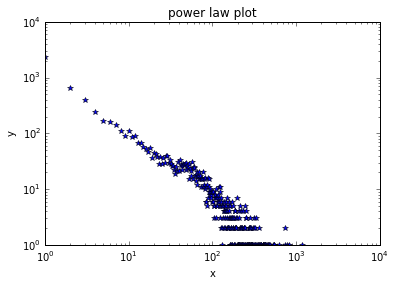

In [6]:
# code to analyze undirected graphs
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
  
# get the degrees for each node (again)
nodes = get_degrees(edges)

v = nodes.values()
# this ensures that we don't have any values more than once
noRep = list(set(v))
noRep.sort()

x = []
y = []
for count in noRep:
    # f is the number of times this value occurs
    f = v.count(count)
    x.append(count)
    y.append(f)
figure()
loglog(x, y, '*')
xlabel('x')
ylabel('y')
title('power law plot')
show()

Directed Graphs
============
Directed graphs are handled slightly differently than regular graphs:
We need to keep track of both incoming and outgoing edges...

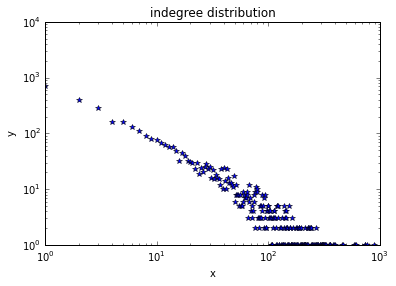

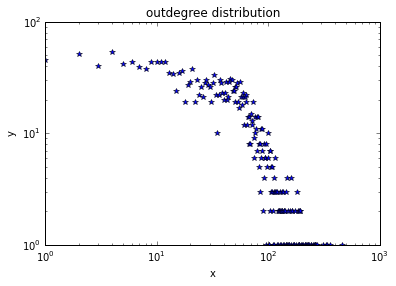

In [9]:
# code to analyze directed graphs
file = open("wikiVote.txt")
lines = file.readlines()
edges = set()
nodes_indegree = {}
nodes_outdegree = {}

# construct the indegree info and edges
# very similar to what we did for directed graphs
for line in lines:
    data = line.split()
    source = int(data[0])
    endpoint = int(data[1])
    # add the edge
    edges.add((source, endpoint))
    # update the count for the number of times we've seen each node
    nodes_indegree[source] = nodes_indegree.get(source, -1) + 1
    nodes_outdegree[endpoint] = nodes_outdegree.get(endpoint, -1) + 1

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

# now show this to the viewer
v_indegree = nodes_indegree.values()
v_outdegree = nodes_outdegree.values()
noRep_indegree = list(set(v_indegree))
noRep_outdegree = list(set(v_outdegree))
noRep_indegree.sort()
noRep_outdegree.sort()

x_indegree = []
y_indegree = []
x_outdegree = []
y_outdegree = []

for count in noRep_indegree:
    f = v_indegree.count(count)
    x_indegree.append(count)
    y_indegree.append(f)
    
for count in noRep_outdegree:
    f = v_outdegree.count(count)
    x_outdegree.append(count)
    y_outdegree.append(f)
    
figure()
loglog(x_indegree, y_indegree, '*')
xlabel('x')
ylabel('y')
title('indegree distribution')
show()   

figure()
loglog(x_outdegree, y_outdegree, '*')
xlabel('x')
ylabel('y')
title('outdegree distribution')
show()


# TODO for this byte
==============
* Choose a graph data set from http://snap.stanford.edu/data/index.html 
* Use the code given above and make sure everything works
* Now explore the way in which k impacts the results. Experiment with different values of k. How does the number of connected components change as you increase k? How does the number of nodes in a the connected components change as you increase k? 
* Can you create a chart that shows the relationship between k and the number of connected components? Chart at least two different data sets and try to write something about how they are different. If you have trouble doing this in code, do it on paper and include an image of the result in your hand in
* [optional] Can you make a version of k-core that works for directed graphs? For directed graphs the node degree is defined to be the in-degree + out-degree.

('largest degree: ', 1167)
# of nodes to be deleted 2315
# of edges left: 101394
# of nodes to be deleted 11
# of edges left: 101383
('largest degree: ', 1167)
# of nodes to be deleted 2955
# of edges left: 100132
# of nodes to be deleted 7
# of edges left: 100119
('largest degree: ', 1167)
# of nodes to be deleted 3343
# of edges left: 98978
# of nodes to be deleted 9
# of edges left: 98953
# of nodes to be deleted 1
# of edges left: 98950
('largest degree: ', 1167)
# of nodes to be deleted 3588
# of edges left: 98005
# of nodes to be deleted 14
# of edges left: 97954
('largest degree: ', 1167)
# of nodes to be deleted 3753
# of edges left: 97197
# of nodes to be deleted 18
# of edges left: 97110
# of nodes to be deleted 1
# of edges left: 97105
('largest degree: ', 1167)
# of nodes to be deleted 3912
# of edges left: 96263
# of nodes to be deleted 20
# of edges left: 96147
('largest degree: ', 1167)
# of nodes to be deleted 4051
# of edges left: 95307
# of nodes to be deleted 30
# of

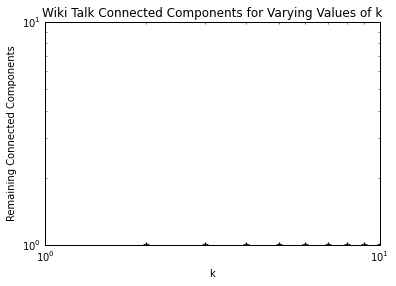

In [7]:
import copy
# Explore how k impacts the number of connected components.
x1 = []
y1 = []
for count in range(2,11):
    # count = kcore value
    x1.append(count)
    core_edges, core_nodes=kcore(edges, count)
    neighborhood = build_neighborhood(core_edges, core_nodes)
    ret = get_connected_components(core_edges, neighborhood, core_nodes)
    y1.append(len(ret))
figure()
loglog(x1, y1, '*')
xlabel('k')
ylabel('Remaining Connected Components')
title('Wiki Talk Connected Components for Varying Values of k')
show()